# PEFT 库 LoRA 实战 - OpenAI Whisper-large-v2

本教程使用 LoRA 在`OpenAI Whisper-large-v2`模型上实现`语音识别(ASR)`任务的微调训练。

同时，我们还结合了`int8` 量化进一步降低训练过程资源开销，同时保证了精度几乎不受影响。

![LoRA](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/peft/lora_diagram.png)

本教程主要训练流程如下：
- 全局参数设置
- 数据准备
    - 下载数据集：训练、验证和评估集
    - 预处理数据：降采样、移除不必要字段等
    - 数据抽样（演示需要）
    - 应用数据集处理（`Dataset.map`）
    - 自定义语音数据处理器
- 模型准备
    - 加载和处理 `int8` 精度 Whisper-Large-v2 模型
    - LoRA Adapter 参数配置
    - 实例化 PEFT Model：`peft_model = get_peft_model(model, config)`
- 模型训练
    - 训练参数配置 Seq2SeqTrainingArguments
    - 实例化训练器 Seq2SeqTrainer
    - 训练模型
    - 保存模型
- 模型推理
    - 使用 `PeftModel` 加载 LoRA 微调后 Whisper 模型
    - 使用 `Pipeline API` 部署微调后 Whisper 实现中文语音识别任务

## 全局参数设置

In [1]:
model_name_or_path = "openai/whisper-large-v2"
model_dir = "models/whisper-large-v2-asr-int8"

language = "Chinese (China)"
language_abbr = "zh-CN"
task = "transcribe"
dataset_name = "mozilla-foundation/common_voice_11_0"

batch_size=64

## 数据准备

### 下载数据集 Common Voice

Common Voice 11.0 数据集包含许多不同语言的录音，总时长达数小时。

本教程以中文数据为例，展示如何使用 LoRA 在 Whisper-large-v2 上进行微调训练。

首先，初始化一个DatasetDict结构，并将训练集（将训练+验证拆分为训练集）和测试集拆分好，按照中文数据集构建配置加载到内存中：

In [2]:
import os
# env=os.getenv('HF_DATASETS_CACHE')
# print(env)

os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
print(os.getenv('HF_ENDPOINT'))
os.environ['HF_DATASETS_CACHE'] = '/mnt/windows/Linux/huggingface/datasets/'
print(os.getenv('HF_DATASETS_CACHE'))
os.environ['HF_HOME'] = '/mnt/windows/Linux/huggingface/'
print(os.getenv('HF_HOME'))
# os.environ['HF_HUB_OFFLINE'] = '0'
# print(os.getenv('HF_HUB_OFFLINE'))

https://hf-mirror.com
/mnt/windows/Linux/huggingface/datasets/
/mnt/windows/Linux/huggingface/
ERROR! Session/line number was not unique in database. History logging moved to new session 61


In [3]:
from datasets import load_dataset, DatasetDict

common_voice = DatasetDict()

common_voice["train"] = load_dataset(dataset_name, language_abbr, split="train", trust_remote_code=True)
common_voice["validation"] = load_dataset(dataset_name, language_abbr, split="validation", trust_remote_code=True)

common_voice["train"][0]

{'client_id': '95368aab163e0387e4fd4991b4f2d8ccfbd4364bf656c860230501fd27dcedf087773e4695a6cf5de9c4f1d406d582283190d065cdfa36b0e2b060cffaca977e',
 'path': '/mnt/windows/Linux/huggingface/datasets/downloads/extracted/1ebb7cfa5f5c252233faeb1f04eaa97b4133c42852ea64aa82eb868e20f657ba/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
 'audio': {'path': '/mnt/windows/Linux/huggingface/datasets/downloads/extracted/1ebb7cfa5f5c252233faeb1f04eaa97b4133c42852ea64aa82eb868e20f657ba/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'zh-CN',
 'segment': ''}

In [4]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 10581
    })
})

## 预处理训练数据集


In [5]:
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoProcessor

# 从预训练模型加载特征提取器
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

# 从预训练模型加载分词器，可以指定语言和任务以获得最适合特定需求的分词器配置
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, language=language, task=task)

# 从预训练模型加载处理器，处理器通常结合了特征提取器和分词器，为特定任务提供一站式的数据预处理
processor = AutoProcessor.from_pretrained(model_name_or_path, language=language, task=task)

/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### 移除数据集中不必要的字段

In [6]:
common_voice = common_voice.remove_columns(
    ["accent", "age", "client_id", "down_votes", "gender", "locale", "path", "segment", "up_votes"]
)

In [7]:
common_voice["train"][0]

{'audio': {'path': '/mnt/windows/Linux/huggingface/datasets/downloads/extracted/1ebb7cfa5f5c252233faeb1f04eaa97b4133c42852ea64aa82eb868e20f657ba/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([-6.82121026e-13, -2.27373675e-12, -2.27373675e-12, ...,
          1.21667399e-05,  3.23003678e-06, -2.43066324e-07]),
  'sampling_rate': 48000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

#### 降采样音频数据

查看`common_voice` 数据集介绍，你会发现其音频是以48kHz的采样率进行采样的.

而`Whisper`模型是在16kHZ的音频输入上预训练的，因此我们需要将音频输入降采样以匹配模型预训练时使用的采样率。

通过在音频列上使用`cast_column`方法，并将`sampling_rate`设置为16kHz来对音频进行降采样。

下次调用时，音频输入将实时重新取样：

In [8]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [9]:
# sampling_rate 从 48KHZ 降为 16KHZ
common_voice["train"][0]

{'audio': {'path': '/mnt/windows/Linux/huggingface/datasets/downloads/extracted/1ebb7cfa5f5c252233faeb1f04eaa97b4133c42852ea64aa82eb868e20f657ba/zh-CN_train_0/common_voice_zh-CN_33211332.mp3',
  'array': array([ 5.09317033e-11, -7.27595761e-12, -6.54836185e-11, ...,
         -5.96661994e-06,  2.71382887e-05,  1.29687978e-05]),
  'sampling_rate': 16000},
 'sentence': '性喜温暖润湿气候且耐寒。'}

### 整合以上数据处理为一个函数

该数据预处理函数应该包括：
- 通过加载音频列将音频输入重新采样为16kHZ。
- 使用特征提取器从音频数组计算输入特征。
- 将句子列标记化为输入标签。

In [10]:
def prepare_dataset(batch):
    audio = batch["audio"]
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

### 数据抽样（演示需要）

在 Whisper-Large-v2 上使用小规模数据进行演示训练，保持以下训练参数不变（batch_size=64）。

使用 640 个样本训练，320个样本验证和评估，恰好使得1个 epoch 仅需10 steps 即可完成训练。

（在 NVIDIA T4 上需要10-15分钟）

In [14]:
small_common_voice = DatasetDict()

small_common_voice["train"] = common_voice["train"].shuffle(seed=16).select(range(640))
small_common_voice["validation"] = common_voice["validation"].shuffle(seed=16).select(range(320))

In [15]:
small_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 640
    })
    validation: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 320
    })
})

### 如果全量训练，则使用完整数据代替抽样

In [11]:
# 抽样数据处理
# tokenized_common_voice = small_common_voice.map(prepare_dataset)

# 完整数据训练，尝试开启 `num_proc=8` 参数多进程并行处理（如阻塞无法运行，则不使用此参数）
tokenized_common_voice = common_voice.map(prepare_dataset, num_proc=8)

In [12]:
tokenized_common_voice

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 29056
    })
    validation: Dataset({
        features: ['audio', 'sentence', 'input_features', 'labels'],
        num_rows: 10581
    })
})

### 自定义语音数据整理器

定义了一个针对语音到文本（Seq2Seq）模型的自定义数据整理器类，特别适用于输入为语音特征、输出为文本序列的数据集。


这个整理器（`DataCollatorSpeechSeq2SeqWithPadding`）旨在将数据点批量打包，将每个批次中的`attention_mask`填充到最大长度，以保持批处理中张量形状的一致性，并用`-100`替换填充值，以便在损失函数中被忽略。这对于神经网络的高效训练至关重要。

In [13]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

# 定义一个针对语音到文本任务的数据整理器类
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any  # 处理器结合了特征提取器和分词器

    # 整理器函数，将特征列表处理成一个批次
    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # 从特征列表中提取输入特征，并填充以使它们具有相同的形状
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # 从特征列表中提取标签特征（文本令牌），并进行填充
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # 使用-100替换标签中的填充区域，-100通常用于在损失计算中忽略填充令牌
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # 如果批次中的所有序列都以句子开始令牌开头，则移除它
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        # 将处理过的标签添加到批次中
        batch["labels"] = labels

        return batch  # 返回最终的批次，准备好进行训练或评估

In [14]:
# 用给定的处理器实例化数据整理器
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

## 模型准备

### 加载预训练模型（int8 精度）

使用 `int8 ` 精度加载预训练模型，进一步降低显存需求。

In [15]:
from transformers import AutoModelForSpeechSeq2Seq

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name_or_path, load_in_8bit=True, device_map="auto")

/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [16]:
# 设置模型配置中的forced_decoder_ids属性为None
model.config.forced_decoder_ids = None  # 这通常用于指定在解码（生成文本）过程中必须使用的特定token的ID，设置为None表示没有这样的强制要求

# 设置模型配置中的suppress_tokens列表为空
model.config.suppress_tokens = []  # 这用于指定在生成过程中应被抑制（不生成）的token的列表，设置为空列表表示没有要抑制的token

### PEFT 微调前的模型处理

在使用 `peft` 训练 int8 模型之前，需要进行一些预处理：
- 将所有非 `int8` 精度模块转换为全精度（`fp32`）以保证稳定性
- 为输入嵌入层添加一个 `forward_hook`，以启用输入隐藏状态的梯度计算
- 启用梯度检查点以实现更高效的内存训练

使用 `peft` 库预定义的工具函数 `prepare_model_for_int8_training`，便可自动完成以上模型处理工作。

In [17]:
from peft import prepare_model_for_int8_training

model = prepare_model_for_int8_training(model)

/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


### LoRA Adapter 配置

在 `peft` 中使用`LoRA`非常简捷，借助 `PeftModel`抽象，我们可以快速使用低秩适配器（LoRA）到任意模型。

通过使用 `peft` 中的 `get_peft_model` 工具函数来实现。

#### 关于 LoRA 超参数的说明：
```
MatMul(B,A) * Scaling
Scaling = LoRA_Alpha / Rank
```

In [18]:
from peft import LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model

# 创建一个LoraConfig对象，用于设置LoRA（Low-Rank Adaptation）的配置参数
config = LoraConfig(
    r=8,  # LoRA的秩，影响LoRA矩阵的大小
    lora_alpha=64,  # LoRA适应的比例因子
    # 指定将LoRA应用到的模型模块，通常是attention和全连接层的投影。
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,  # 在LoRA模块中使用的dropout率
    bias="none",  # 设置bias的使用方式，这里没有使用bias
)

### 使用get_peft_model函数和给定的配置来获取一个PEFT模型

In [19]:
peft_model = get_peft_model(model, config)

In [20]:
# 打印 LoRA 微调训练的模型参数
peft_model.print_trainable_parameters()

trainable params: 3,932,160 || all params: 1,547,237,120 || trainable%: 0.25414074863974306


## 模型训练

#### Seq2SeqTrainingArguments 训练参数

**关于设置训练步数和评估步数**

基于 epochs 设置：

```python
    num_train_epochs=3,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
```

基于 steps 设置：

```python
    max_steps=100, # 训练总步数
    evaluation_strategy="steps", 
    eval_steps=25, # 评估步数
```

In [21]:
from transformers import Seq2SeqTrainingArguments

# 设置序列到序列模型训练的参数
training_args = Seq2SeqTrainingArguments(
    output_dir=model_dir,  # 指定模型输出和保存的目录
    per_device_train_batch_size=batch_size,  # 每个设备上的训练批量大小
    learning_rate=1e-3,  # 学习率
    num_train_epochs=3,  # 训练的总轮数
    evaluation_strategy="epoch",  # 设置评估策略，这里是在每个epoch结束时进行评估
    warmup_steps=50,  # 在训练初期增加学习率的步数，有助于稳定训练
    fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
    per_device_eval_batch_size=batch_size,  # 每个设备上的评估批量大小
    generation_max_length=128,  # 生成任务的最大长度
    logging_steps=10,  # 指定日志记录的步骤，用于跟踪训练进度
    remove_unused_columns=False,  # 是否删除不使用的列，以减少数据处理开销
    label_names=["labels"],  # 指定标签列的名称，用于训练过程中
    # evaluation_strategy="steps",
    # eval_steps=25,
)

### 实例化 Seq2SeqTrainer 训练器

In [22]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=peft_model,
    train_dataset=tokenized_common_voice["train"],
    eval_dataset=tokenized_common_voice["validation"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
)
peft_model.config.use_cache = False

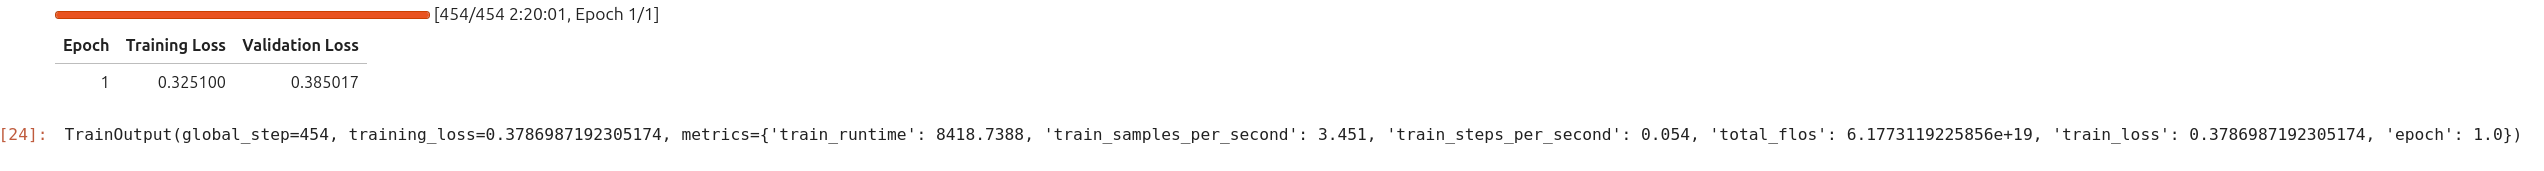
上图是全量执行一次，下面是执行了三次epoch训练的结果，每执行完一次epoch进行验证，training loss明显降低，validation loss变化不明显

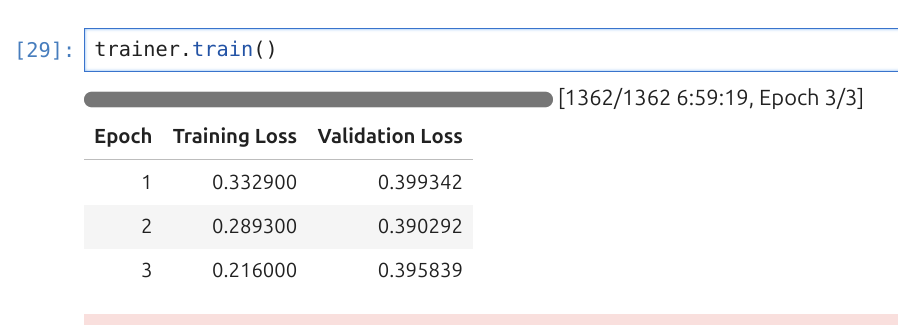

In [23]:
trainer.train()

/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,0.338700,0.397187
2,0.293600,0.382220
3,0.214700,0.387298


Checkpoint destination directory models/whisper-large-v2-asr-int8/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/home/chenglim/miniconda3/envs/peft/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from

TrainOutput(global_step=1362, training_loss=0.3142878919533521, metrics={'train_runtime': 20090.3776, 'train_samples_per_second': 4.339, 'train_steps_per_second': 0.068, 'total_flos': 1.855661438140416e+20, 'train_loss': 0.3142878919533521, 'epoch': 3.0})

### 保存 LoRA 模型(Adapter)

In [24]:
trainer.save_model(model_dir)

In [25]:
peft_model.eval()

PeftModel(
  (base_model): LoraModel(
    (model): WhisperForConditionalGeneration(
      (model): WhisperModel(
        (encoder): WhisperEncoder(
          (conv1): Conv1d(80, 1280, kernel_size=(3,), stride=(1,), padding=(1,))
          (conv2): Conv1d(1280, 1280, kernel_size=(3,), stride=(2,), padding=(1,))
          (embed_positions): Embedding(1500, 1280)
          (layers): ModuleList(
            (0-31): 32 x WhisperEncoderLayer(
              (self_attn): WhisperSdpaAttention(
                (k_proj): Linear8bitLt(in_features=1280, out_features=1280, bias=False)
                (v_proj): lora.Linear8bitLt(
                  (base_layer): Linear8bitLt(in_features=1280, out_features=1280, bias=True)
                  (lora_dropout): ModuleDict(
                    (default): Dropout(p=0.05, inplace=False)
                  )
                  (lora_A): ModuleDict(
                    (default): Linear(in_features=1280, out_features=8, bias=False)
                  )
            